# Brain Tumor Detection with VGG-16 Model
---
---

# <a id='env'># Setting up the Environment</a>

In [1]:
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import time
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import *
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model

RANDOM_SEED = 123

C:\Users\taufi\Anaconda3\envs\tf_14\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

C:\Users\taufi\Anaconda3\envs\tf_14\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

C:\Users\taufi\Anaconda3\envs\tf_14\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

C:\Users\taufi\Anaconda3\envs\tf_14\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will b

In [2]:
IMG_PATH = os.path.join('..', 'Datasets', 'dataset_brain_mri_orig')
TEST_PATH = os.path.join('..', 'Datasets', 'dataset_brain_mri', 'TEST')
TRAIN_PATH = os.path.join('..', 'Datasets', 'dataset_brain_mri', 'TRAIN')
VALIDATION_PATH = os.path.join('..', 'Datasets', 'dataset_brain_mri', 'VALIDATION')

In [3]:
def split_dataset():
    for CLASS in os.listdir(IMG_PATH):
        if not CLASS.startswith('.'):
            IMG_NUM = len(os.listdir(os.path.join(IMG_PATH, CLASS)))
            for (n, FILE_NAME) in enumerate(os.listdir(os.path.join(IMG_PATH, CLASS))):
                img = os.path.join(IMG_PATH, CLASS, FILE_NAME)
                if n < 5:
                    shutil.copy(img, os.path.join(TEST_PATH, CLASS.upper(), FILE_NAME))
                elif n < 0.8 * IMG_NUM:
                    shutil.copy(img, os.path.join(TRAIN_PATH, CLASS.upper(), FILE_NAME))
                else:
                    shutil.copy(img, os.path.join(VALIDATION_PATH, CLASS.upper(), FILE_NAME))

In [4]:
split_dataset()

# <a id='import'># Data Import and Preprocessing</a>

In [5]:
def load_data(dir_path):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = {}
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(os.path.join(dir_path, path)):
                if not file.startswith('.'):
                    img = cv2.imread(os.path.join(dir_path, path, file))
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    
    return X, y, labels

In [6]:
# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_PATH)
X_test, y_test, _ = load_data(TEST_PATH)
X_val, y_val, _ = load_data(VALIDATION_PATH)

 50%|██████████████████████████████████████████                                          | 1/2 [00:00<00:00,  9.35it/s]

193 images loaded from ..\Datasets\dataset_brain_mri\TRAIN directory.
12 images loaded from ..\Datasets\dataset_brain_mri\TEST directory.


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.65it/s]

50 images loaded from ..\Datasets\dataset_brain_mri\VALIDATION directory.


In [7]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Let's take a look at the distribution of classes among sets:

In [8]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

In [11]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desire number of image (n) from the spesified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 5
        i = int(n/j)
        
        plt.figure(figsize = (20, 15))
        c = 1
        for img in imgs:
            plt.subplot(i , j, c)
            plt.imshow(img[0])
            
            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

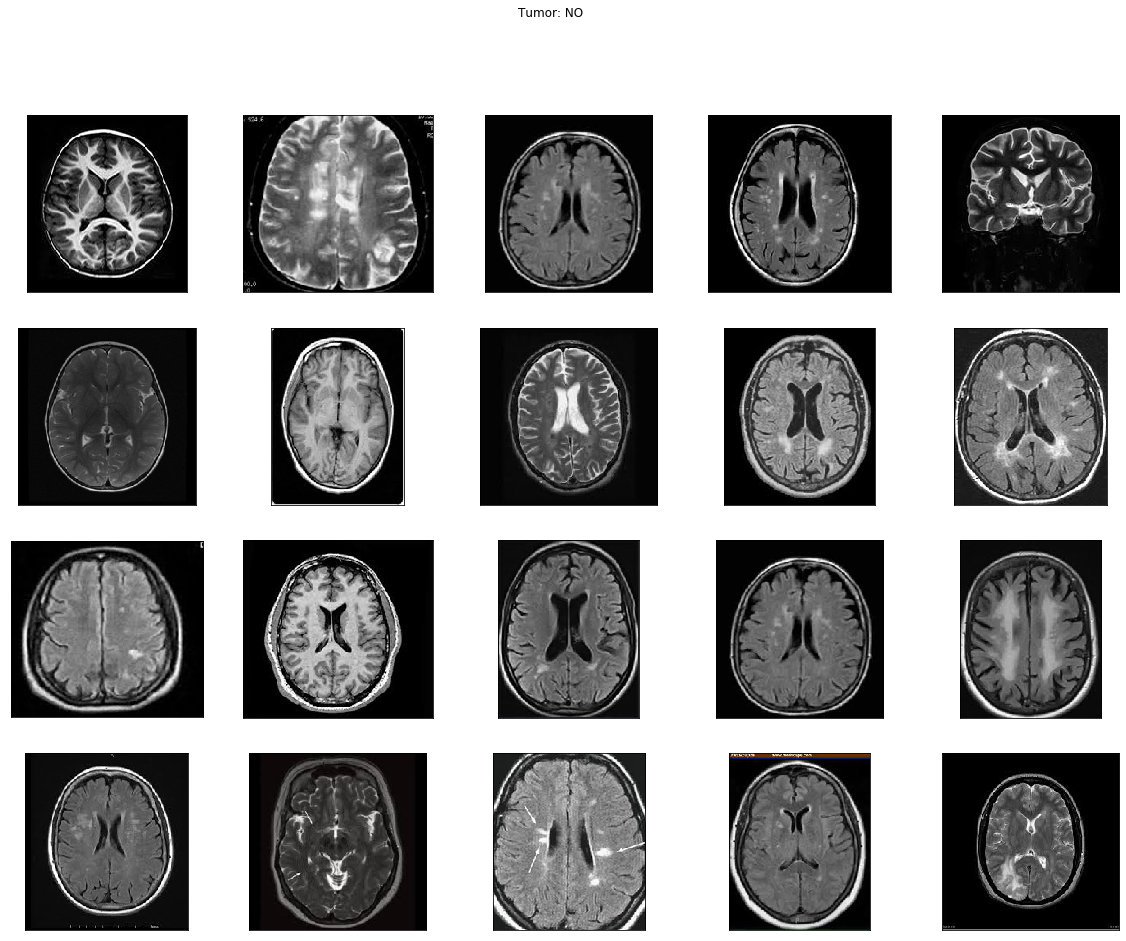

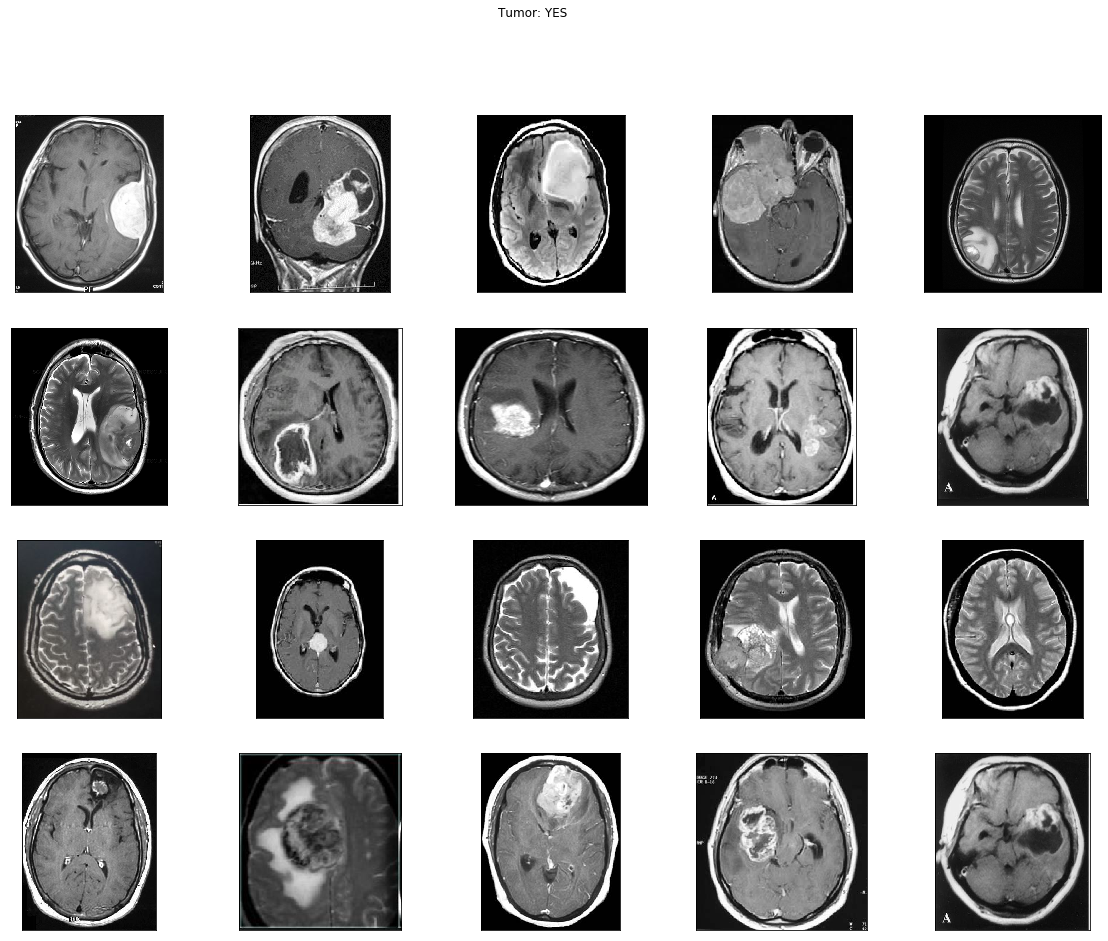

<Figure size 432x288 with 0 Axes>

In [12]:
plot_samples(X_train, y_train, labels, 20)

As you can see, images have different `width` and `height` and diffent size of "black corners". Since the image size for VGG-16 imput layer is `(224,224)` some wide images may look weird after resizing. Histogram of ratio distributions (`ratio = width/height`):

In [12]:
RATIO_LIST = []
for set in (X_train, X_test, X_val):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])
        
plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

AttributeError: 'NoneType' object has no attribute 'shape'

The first step of "normalization" would be to crop the brain out of the images. I used technique which was perfectly described in [pyimagesearch](https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/) blog and I highly suggest to looks deeper into it.

In [13]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

Let's look at example what this function will do with MRI scans:

In [23]:
IMG_SIZE = (224, 224)

img = cv2.imread(os.path.join(IMG_PATH, 'yes', 'Y18.jpg'))
img = cv2.resize(
    img,
    dsize = IMG_SIZE,
    interpolation = cv2.INTER_CUBIC
)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

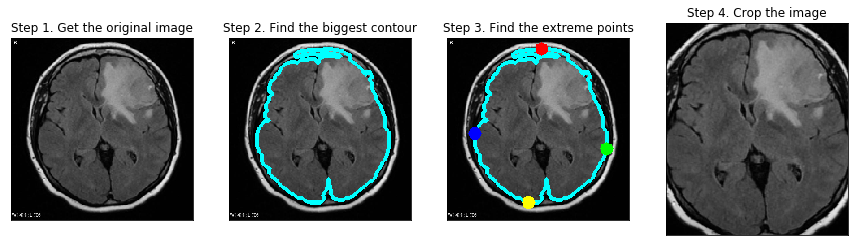

In [22]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.
plt.show()

In [16]:
# apply this for each set
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

error: OpenCV(4.1.1) C:\projects\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


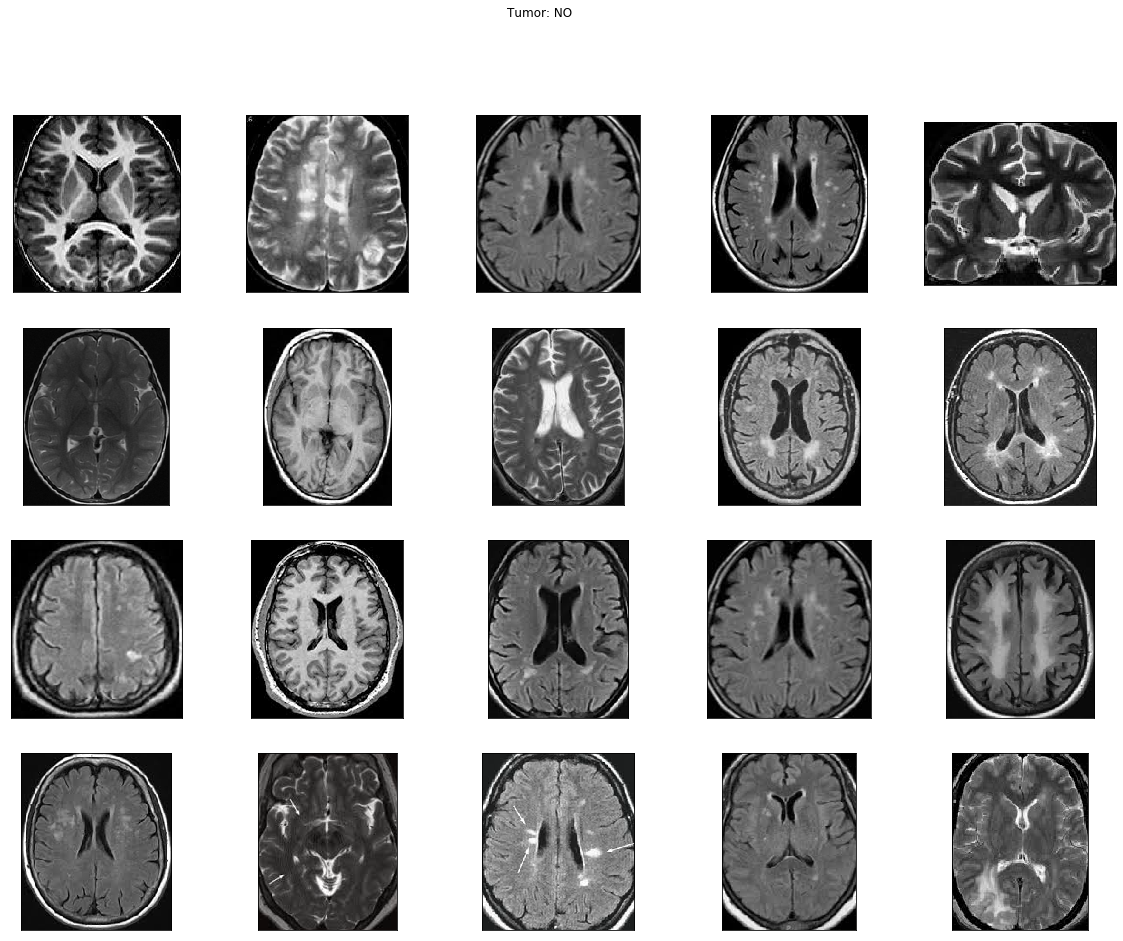

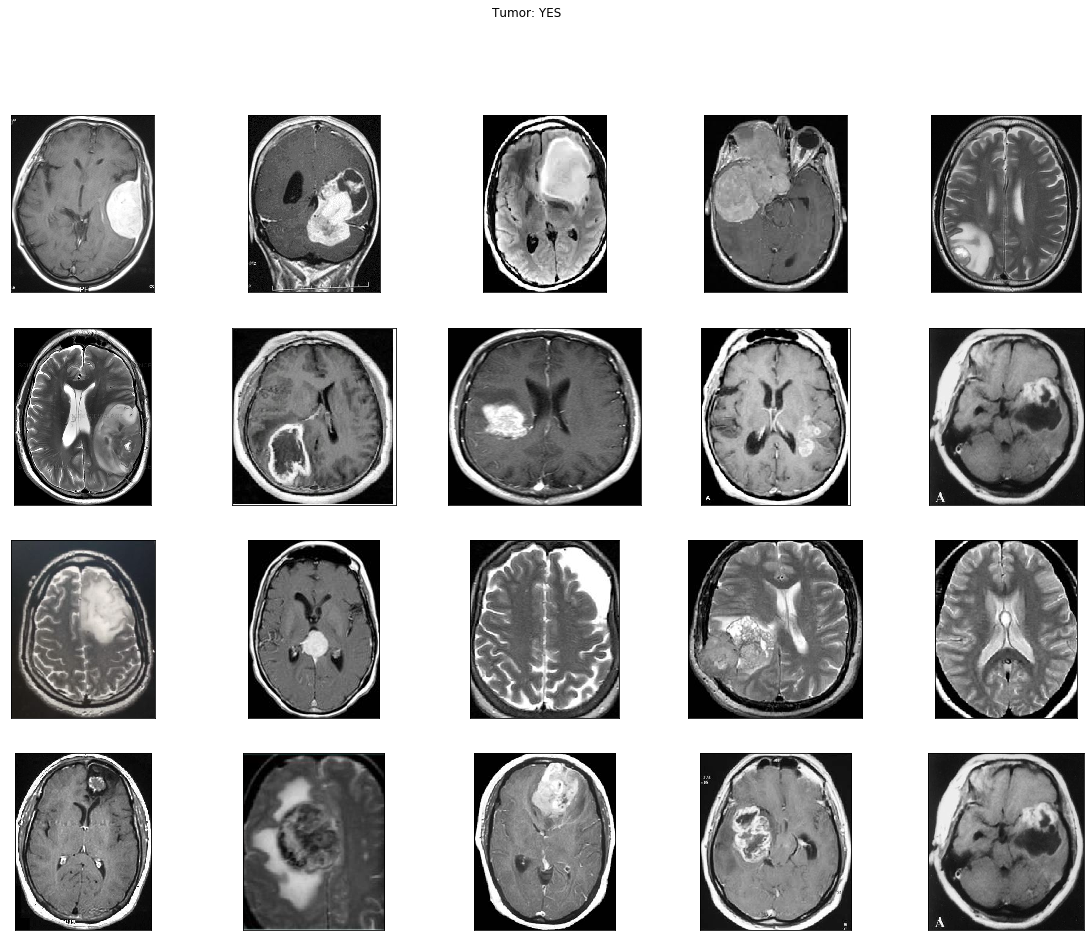

In [18]:
plot_samples(X_train_crop, y_train, labels, 20)

In [ ]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imgclass) in zip(x_set, y_set):
        if imgclass == 0:
            cv2.imwrite(os.path.join(folder_name, 'NO', str(i)+'.jpg'), img)
        else:
            cv2.imwrite(os.path.join(folder_name, 'YES', str(i)+'.jpg'), img)
        i += 1

In [ ]:
TRAIN_CROP_PATH = os.path.join('..', 'Datasets', 'dataset_brain_mri_cropped', 'TRAIN')
TEST_CROP_PATH = os.path.join('..', 'Datasets', 'dataset_brain_mri_cropped', 'TEST')
VALIDATION_CROP_PATH = os.path.join('..', 'Datasets', 'dataset_brain_mri_cropped', 'VALIDATION')

In [ ]:
save_new_images(X_train_crop, y_train, TRAIN_CROP_PATH)
save_new_images(X_val_crop, y_val, VALIDATION_CROP_PATH)
save_new_images(X_test_crop, y_test, TEST_CROP_PATH)

The next step would be resizing images to `(224,224)` and applying preprocessing needed for VGG-16 model input.

In [ ]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-16 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [ ]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

### <a id='demo'>### Demo</a>

Example from one image how does augmentation look like.

In [ ]:
# set the paramters we want to change randomly
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

In [ ]:
x = X_train_crop[0]  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in demo_datagen.flow(x, batch_size=1, 
                               save_to_dir='preview', 
                               save_prefix='aug_img', 
                               save_format='jpg'):
    i += 1
    if i > 20:
        break 

In [ ]:
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()